In [1]:
import tensorflow.keras.backend as K
import tensorflow as tf
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt
import random

2023-06-03 12:24:15.279705: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-03 12:24:15.313053: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-03 12:24:15.313658: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-03 12:24:16.172095: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.__version__

'2.12.0'

In [3]:
DATASET_PATH = '/home/irizqy/ml_ws/bangkit-ws/data/bizz.it-sim_dataset'

In [4]:
pair_ims = []
labels = []

In [5]:
im_path_arr = os.listdir(DATASET_PATH)
im_classes_arr = []

for file in im_path_arr:
    im_classes_arr.append(file.split('_')[0])

im_classes_arr = np.asarray(im_classes_arr)

In [6]:
classes = np.unique(im_classes_arr)

dict_keys = {val:key for key, val in enumerate(classes.flatten())}

In [7]:
grouped_im_path = [np.where(im_classes_arr == cls)[0] for cls in classes]

In [8]:
for file in im_path_arr:
    file_cls = file.split('_')[0]
    cls = dict_keys[file_cls]

    current_im = cv.imread(os.path.join(DATASET_PATH, file))
    current_im = cv.cvtColor(current_im, cv.COLOR_BGR2RGB)
    current_im = cv.resize(current_im, (150, 150))
    current_im = current_im / 255

    pos_idx = np.random.choice(grouped_im_path[cls], 1)[0]
    pos_pair_im = cv.imread(os.path.join(DATASET_PATH, im_path_arr[pos_idx]))
    pos_pair_im = cv.cvtColor(pos_pair_im, cv.COLOR_BGR2RGB)
    pos_pair_im = cv.resize(pos_pair_im, (150, 150))
    pos_pair_im = pos_pair_im / 255

    pair_ims.append((current_im, pos_pair_im))
    labels.append(1)

    neg_idx = np.random.choice(np.where(im_classes_arr != file_cls)[0], 1)[0]
    neg_pair_im = cv.imread(os.path.join(DATASET_PATH, im_path_arr[neg_idx]))
    neg_pair_im = cv.cvtColor(neg_pair_im, cv.COLOR_BGR2RGB)
    neg_pair_im = cv.resize(neg_pair_im, (150, 150))
    neg_pair_im = neg_pair_im / 255

    pair_ims.append((current_im, neg_pair_im))
    labels.append(0)

In [9]:
np_ims = np.asarray(pair_ims)
np_labels = np.asarray(labels)

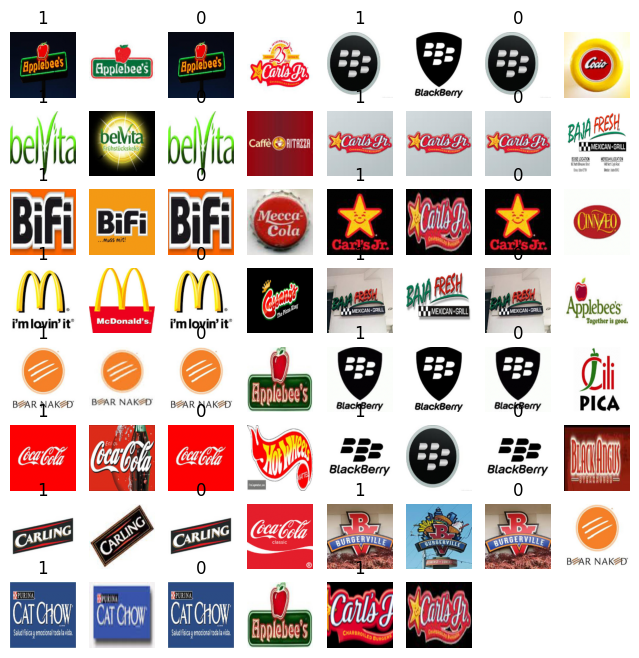

In [10]:
w = 20
h = 15
fig = plt.figure(figsize=(8, 8))
columns = 8
rows = 8
for index, i in enumerate(range(1, (columns*rows +1)//2)):
    img = np_ims[index][0]
    fig.add_subplot(rows, columns, 2*i - 1) 
    if i % 2 == 1:
        plt.title('1')
    else:
        plt.title('0')
    plt.imshow(img)
    plt.axis('off')
    img = np_ims[index][1]
    fig.add_subplot(rows, columns, 2*i)
    plt.imshow(img)
    plt.axis('off')


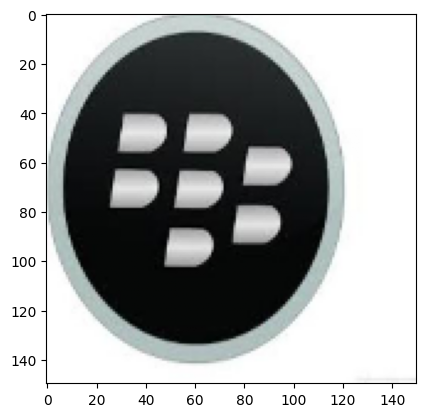

In [11]:
plt.imshow(np_ims[2][0])

In [12]:
IMG_SHAPE = (150, 150, 3)
BATCH_SIZE = 4
EPOCHS = 50

In [13]:
class SiameseModel:

    def __init__(self, input_shape, embedding_dim=300):
        self.input_shape = input_shape
        self.embedding_dim = embedding_dim

    def _build(self):
        inputs = tf.keras.layers.Input(self.input_shape)
        
        x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(inputs)
        x = tf.keras.layers.MaxPooling2D()(x)

        x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
        x = tf.keras.layers.MaxPooling2D()(x)

        x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(inputs)
        x = tf.keras.layers.MaxPooling2D()(x)
        x = tf.keras.layers.Dropout(.2)(x)

        pooled_output = tf.keras.layers.GlobalAveragePooling2D()(x)
        outputs = tf.keras.layers.Dense(self.embedding_dim)(pooled_output)

        model = tf.keras.Model(inputs, outputs)

        return model

In [14]:
# sm = SiameseModel(IMG_SHAPE)

# featureExtractor = sm._build()
# featureExtractor.summary()

base_cnn =  tf.keras.applications.resnet.ResNet50(
    weights="imagenet", input_shape=IMG_SHAPE, include_top=False
)

cnn_model = base_cnn.get_layer('conv5_block3_2_conv')

flatten = tf.keras.layers.GlobalAveragePooling2D()(cnn_model.output)

featureExtractor = tf.keras.Model(base_cnn.input, flatten)

# for layer in featureExtractor.layers[:10]:
#     layer.trainable = False

2023-06-03 12:24:23.291764: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-03 12:24:23.292133: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [15]:
base_cnn.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']      

In [16]:
def euclidean_distance(vectors):
	# unpack the vectors into separate lists
	(feats_A, feats_B) = vectors
	# compute the sum of squared distances between the vectors
	sum_squared = K.sum(K.square(feats_A - feats_B), axis=1,
		keepdims=True)
	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sum_squared, K.epsilon()))

In [17]:
def cosine_similarity(vectors):
    (featsA, featsB) = vectors
    sum_product = K.sum(featsA*featsB)
    sum_squared_featsA = K.sqrt(K.sum(featsA**2, keepdims=1, axis=1))
    sum_squared_featsB = K.sqrt(K.sum(featsB**2, keepdims=1, axis=1))
    sum_mul_feats = sum_squared_featsA * sum_squared_featsB

    return sum_product / sum_mul_feats

In [25]:
def plot_training(H):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	# plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	# plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")

In [19]:
# configure the siamese network
print("[INFO] building siamese network...")
imgA = tf.keras.layers.Input(shape=IMG_SHAPE)
imgB = tf.keras.layers.Input(shape=IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

[INFO] building siamese network...


In [20]:
# finally, construct the siamese network
distance = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(distance)
model = tf.keras.Model(inputs=[imgA, imgB], outputs=outputs)

In [21]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 512)          22526848    ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

In [22]:
# compile the model
tf.keras.backend.clear_session()

print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer="adam",
	metrics=["accuracy"])
# train the model
print("[INFO] training model...")
history = model.fit(
	[np_ims[:, 0], np_ims[:, 1]], np_labels[:],
	# validation_data=([np_ims[251:, 0], np_ims[251:, 1]], np_labels[251:]),
	batch_size=BATCH_SIZE, 
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training model...
Epoch 1/50
136/136 [==============================] - 101s 643ms/step - loss: 0.7281 - accuracy: 0.5129
Epoch 2/50
136/136 [==============================] - 91s 668ms/step - loss: 0.6905 - accuracy: 0.5018
Epoch 3/50
136/136 [==============================] - 88s 650ms/step - loss: 0.6987 - accuracy: 0.5643
Epoch 4/50
136/136 [==============================] - 89s 652ms/step - loss: 0.6833 - accuracy: 0.5772
Epoch 5/50
136/136 [==============================] - 88s 650ms/step - loss: 0.6815 - accuracy: 0.5901
Epoch 6/50
136/136 [==============================] - 89s 652ms/step - loss: 0.6826 - accuracy: 0.5919
Epoch 7/50
136/136 [==============================] - 89s 651ms/step - loss: 0.6781 - accuracy: 0.6011
Epoch 8/50
136/136 [==============================] - 88s 651ms/step - loss: 0.6754 - accuracy: 0.6213
Epoch 9/50
136/136 [==============================] - 89s 651ms/step - loss: 0.6811 - accuracy: 0.5956
Epoch 10/50
136/136 [

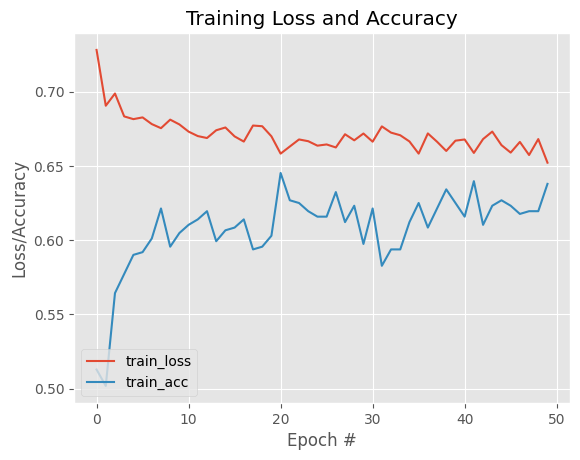

In [26]:
plot_training(history)

In [27]:
model.save('/home/irizqy/ml_ws/bangkit-ws/src/logo-detector/im_similar')

INFO:tensorflow:Assets written to: /home/irizqy/ml_ws/bangkit-ws/src/logo-detector/im_similar/assets


INFO:tensorflow:Assets written to: /home/irizqy/ml_ws/bangkit-ws/src/logo-detector/im_similar/assets


In [34]:
from PIL import Image

preds = []

test_data = os.listdir('/home/irizqy/ml_ws/bangkit-ws/data/bizz.it-sim_dataset')

im1 = Image.open('/home/irizqy/ml_ws/bangkit-ws/src/ops/cropped-logo.jpg').resize((150, 150))
im1 = np.asarray(im1)
im1 = im1 / 255

image1 = np.expand_dims(im1, 0)

im2 = Image.open('/home/irizqy/ml_ws/bangkit-ws/data/bizz.it-sim_dataset/bb_6.jpg').resize((150, 150))
# im2 = Image.open('/home/irizqy/ml_ws/bangkit-ws/data/LogoDet-3K/Food/mcdonalds/3.jpg').resize((150, 150))
im2 = np.asarray(im2)
im2 = im2 / 255

image2 = np.expand_dims(im2, 0)
model.predict((image1, image2))[0][0]

# for file in test_data:
#     im2 = Image.open(os.path.join('/home/irizqy/ml_ws/bangkit-ws/data/bizz.it-sim_dataset', file)).resize((150, 150))
#     im2 = np.asarray(im2)
#     im2 = im2 / 255

#     image2 = np.expand_dims(im2, 0)
#     pred = model.predict((image1, image2))[0][0]
#     preds.append(pred)

# preds = np.asarray(preds)

1/1 [==============================] - 0s 63ms/step


0.61138123

In [31]:
max_idx = np.argmax(preds)
print(max_idx)

1


In [32]:
test_data[max_idx]

'bb_6.jpg'